# Advanced Data Analytics for Management Support
***
## Final Assignment: Medium Claps Prediction

<span style='font-size:16px;'>Alex Truesdale</span><span style='font-size:13px;'><strong> 598854</strong></span>

***
# Outline

1. [Importing Packages](#importpackages)
2. [Read Data & Examine / Clean](#datareading)
     *   [Bearbeitung: Test](#testedit)
     *   [Bearbeitung: Train](#trainedit)
     
3. [Data Pre-Processing](#preprocessing)
     *   [Keras Tokenising & Sequencing](#keras)
     
4. [Modeling](#modeling)
     *   [Simple(r) Models](#benchmarks)
     *   [Neural Networks](#nns)

5. [Conclusions](#conclusions)

<a id='importpackages'></a>
***
# Import Packages

### Standard Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import re

from statistics import median as median

!pip install pprint
from pprint import pprint

pd.set_option("display.max_columns", 50)
pd.set_option('display.max_colwidth', 50)
pd.options.display.max_rows = 1000
pd.options.mode.chained_assignment = None
df = pd.DataFrame

plt.style.use('default')
%matplotlib inline

### NLTK / NLP Modules

In [2]:
from string import ascii_letters, punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

!pip install unidecode
import unidecode

!pip install spacy
import spacy
nlp = spacy.load('en')

!pip install beautifulsoup4
from bs4 import BeautifulSoup

### Machine Learning Modules (SKLearn & XGBoost)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost

### Neural Net Modules (Keras & Tensorflow)

In [4]:
import os
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, CuDNNLSTM, CuDNNGRU, LSTM, GRU, GlobalAveragePooling1D, Embedding, Dropout, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop
from keras.models import load_model, Model

!pip install hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/final_assignment/data')

<a id='datareading'></a>
***
# Read Data & Examine / Clean

In the following cells, a basic exploration of the data shows an incoming set of 279,577 rows from the aggregate data set. Each row has 50 features, all of which presumably scraped from the HTML of the given Medium article. Conversely, the test data (514 rows) has only 6 features. In order to train a model appropriate for the test data, features need to be culled from the train data and generated for the test data where possible. This will be discussed shortly.

Of the default features available, the obvious features of interest are the body text and headline text, which will be encoded and used as input for a GRU. The assumption is that these text embeddings will be the most informative indicators for determining the target variable – number of claps for the article.

Later, non-text features will be fed to well-performing, non-neural-network models as baseline regressors for the purpose of evaluating the non-network alternatives. Similarly, within the realm of neural networks, simple architectures will bear the first testing runs as benchmarks for more complex builds.

Recursive Neural Networks (RNNs) are the network of choice for text data as the structure of a sentence or body of text is sequential. RNNs hold a representation of state throughout their processing, which allows sequential data, in this case, textual context, to be captured in the model. Normal feed-forward neural networks take input values one at a time to derive relationships but cannot otherwise, by nature of their structural qualities, handle sequences with meaningful sophistication.

In [0]:
train_aggregate = pd.read_csv('train.csv')

In [0]:
test = pd.read_csv('test.csv')
test = test.drop('Unnamed: 0', axis=1)
test = test.drop('index', axis=1)

In [0]:
print(train_aggregate.shape)
print(test.shape)

(279577, 50)
(514, 6)


In [0]:
train_aggregate.dtypes

audioVersionDurationSec          int64
codeBlock                       object
codeBlockCount                 float64
collectionId                    object
createdDate                     object
createdDatetime                 object
firstPublishedDate              object
firstPublishedDatetime          object
imageCount                       int64
isSubscriptionLocked              bool
language                        object
latestPublishedDate             object
latestPublishedDatetime         object
linksCount                       int64
postId                          object
readingTime                    float64
recommends                       int64
responsesCreatedCount            int64
socialRecommendsCount            int64
subTitle                        object
tagsCount                        int64
text                            object
title                           object
totalClapCount                   int64
uniqueSlug                      object
updatedDate              

In [0]:
test.dtypes

Author                object
PublicationDetails    object
Responses             object
Header                object
Text                  object
Length                 int64
dtype: object

<a id='testedit'></a>
***
## Bearbeitung: Test

### Derivable Features from Test

Of the 50 features available in the aggregate training set, not all are able to be recreated in the test set, nor are all of them likely to be strong predictors. The following features are derivable through relatively simple text processing:

- Age of Article (time since publish)
- Read Time
- Links Count
- Historical Author Performance (popularity, median claps from train)
- Historical Publication Performance (popularity, median claps from train)

### RegEx Treatment of 'PublicationDetails' Feature

The 'PublicationDetails' feature in the test data contains the information for the author of the article, the publisher, and when the story was published. With the RegEx scalpel, these features can be teased out from the original string.

In [0]:
def string_splitter(row):
  """Split publish data string into contituent features."""
  
  published_string = row['PublicationDetails']
  date_found = re.search(r'[A-Z][a-z]{1,2}\s\d{1,2}.{0,6}$', published_string)[0]
  
  if ' in ' in published_string:
    author = re.search(r'^.*(?=\sin\s)', published_string)[0]
  else:
    author = re.sub(date_found + '$', '', published_string)
  
  publication = re.sub(date_found + '$', '', published_string)
  publication = re.sub('^' + author, '', publication)
  publication = publication.lstrip(' in ')
  
  if not re.match(r'.*\d{4}$', date_found):
    date_found = date_found + ', 2018'
        
  return pd.Series([author, date_found, publication])
  

The above-defined string_splitter function is now applied to the 'PublicationDetails' column, producing a new DF with the derived features. These features are then shuffled into the master test frame and 'PublicationDetails' removed. 

In [0]:
split_string_df = test.apply(lambda row: string_splitter(row), axis=1)
split_string_df.columns=['author', 'published', 'publication']

test['author'] = split_string_df['author']
test['published'] = split_string_df['published']
test['publication'] = split_string_df['publication']

test = test.drop('PublicationDetails', axis=1)
test = test.drop('Author', axis=1)

Dataframe columns are renamed here to a more standard, readable format.

In [0]:
test.columns = ['responses', 'header', 'text', 'length', 'author', 'published', 'publication']

### Derive Article Age

With a standardised publication date column, the age of articles can be calculated (using todays date as an anchoring point).

In [0]:
test['published'] = pd.to_datetime(test['published'])
test['article_age'] = (pd.datetime.today() - test['published']).dt.days
test = test.drop(['published'], axis=1)

### Modify Responses: String to Integer

The count of responses columns contains strings representing the integer count of responses to a given article. Here, the text is stripped from these cells, and they are converted to integers as useful input for the later-introduced models.

In [0]:
test['responses'] = test['responses'].fillna(value='0 responses')
test['responses'] = test.apply(lambda row: re.search(r'.*(?=\srespons)', row['responses'])[0], axis=1)
test['responses'] = test['responses'].fillna(value='0 responses')
test['responses'] = test['responses'].str.replace(',', '')
test['responses'] = test['responses'].astype(int)

In [0]:
test.dtypes

responses       int64
header         object
text           object
length          int64
author         object
publication    object
article_age     int64
dtype: object

### Find Count Images

A rough assessment of the count of images in each respective article is carried out here. Looking for img tags in the article text (which appears to contain raw HTML tags from scraping), the count of these tags can stand as a representation of image count, which ultimately factors into reading time.


In [0]:
test['count_images'] = test.apply(lambda row: len(re.findall(r'<img.*>', row['text'])), axis=1)

### Remove HTML Tags

Now it's time to get rid of those pesky HTML tags. They will not help anymore from here on out.

In [0]:
test['text'] = test.apply(lambda row: BeautifulSoup(row['text']).text, axis=1)

### Fix end-of-punctuation Spacing

A number of articles have the problem where there are missing spaces after punctuation. This is an issue when the text is later tokenised, using spaces as a delimiter. The following code block searches for instances of punctuation which is followed by a capital letter (not a space, lowercase, or quotation mark) and inserts a space there.

In [0]:
test['text'] = test.apply(lambda row: re.sub(r'(?<=[.,:;"!?])(?=[^\sa-z\"])', r' ', row['text']), axis=1)
test['text'] = test.apply(lambda row: re.sub(r'\xa0', r' ', row['text']), axis=1)

### Estimate Word Count

With spacing more or less properly represented in the test data frame body text, the articles can be split on white space to take an estimate of the word count in each piece.

In [0]:
test['word_count'] = test.apply(lambda row: len(row['text'].split()), axis=1)
test = test.drop(['length'], axis=1)

### Calculate Reading Time

Finally, with word and image counts available. Article length in reading time can be calculated (estimated). Using information from Medium.com on [calculating reading time of an article](https://help.medium.com/hc/en-us/articles/214991667-Read-time), the following equation uses word and image count to produce the feature 'read_time'.

In [0]:
test['read_time'] = test.apply(lambda row: 265 / row['word_count'] + 12 * row['count_images'], axis=1)
test = test.drop(['word_count'], axis=1)
test = test.drop(['count_images'], axis=1)

### Fix Publication Strings

In the final steps of preparing the test data, it is noticeable that some of the publisher names might vary from one another whilst representing, in fact, the same publisher. To test this, a quick RegEx match is performed for publications with differing white space or which have additional web extensions at their end.

In [0]:
publications_train = list(train_aggregate['publicationname'].value_counts().index)
publications_test = list(test['publication'].value_counts().index)

In [0]:
pub_test_list = [pub for pub in publications_test if re.match(r'.*\.\w+$', pub)]
pub_test_list

['HackerNoon.com',
 'freeCodeCamp.org',
 'blog.Stockphoto.com',
 'ThinkGrowth.org',
 'WAX.io']

In [0]:
pub_intersect = [pub_train for pub_test in pub_test_list for pub_train in publications_train if pub_train.replace(' ', '').lower() in pub_test.lower()]
pub_intersect

['Hacker Noon', 'freeCodeCamp.org', 'ThinkGrowth.org']

Here, 'HackerNoon.com' needs to be converted to 'Hacker Noon'.

In [0]:
test['publication'] = test['publication'].replace(['HackerNoon.com'], 'Hacker Noon')

<a id='trainedit'></a>
***
## Bearbeitung: Train

The training data set comes with 50 features to identify each row. Typically, more features is a good thing in machine learning, but not all features are created equal. Some are not well formatted, are trivial, or, in the case of this particular problem, aren't able to be reflected in the test data.

Once a model is trained on train data. Only test sets with the same features can be fed to the model for prediction. The test data is the limiting factor here, which dictates which train features can be kept or thrown out.

### Drop Features Which Cannot Translate (easily) to Testing

In [0]:
drop_me = [
    'audioVersionDurationSec',
    'codeBlock',
    'codeBlockCount',
    'createdDate',
    'createdDatetime',
    'firstPublishedDate',
    'isSubscriptionLocked',
    'latestPublishedDate',
    'latestPublishedDatetime',
    'uniqueSlug',
    'updatedDate',
    'updatedDatetime',
    'vote',
    'publicationfacebookPageName',
    'publicationpublicEmail',
    'publicationslug',
    'publicationtags',
    'publicationtwitterUsername',
    'scrappedDate',
    'bio',
    'userId',
    'userName',
    'name',
    'tag_name',
    'slug',
    'postCount',
    'usersFollowedCount',
    'collectionId',
    'socialRecommendsCount',
    'recommends',
    'tagsCount',
    'publicationdescription',
    'publicationdomain',
    'linksCount',
    'imageCount',
    'usersFollowedByCount',
    'publicationfollowerCount',
    'wordCount',
    'url',
    'subTitle'
]

In [0]:
train_aggregate = train_aggregate[[column for column in train_aggregate.columns if not column in drop_me]]

In [0]:
train_aggregate.dtypes

firstPublishedDatetime     object
language                   object
postId                     object
readingTime               float64
responsesCreatedCount       int64
text                       object
title                      object
totalClapCount              int64
publicationname            object
author                     object
dtype: object

### Condense Articles to Single Rows

The train set also carries a number of 'duplicate' rows. These are not duplicates along all 50 features. Were all 50 of these features maintained, perhaps it would be incorrect to simply remove the rows which are duplicates in their 'postId'. In this case, however, considering only the features maintained after the above culling, these pseudo-duplicates are indeed pure duplicates and can be safely disposed of.

In [0]:
train_aggregate.drop_duplicates('postId', inplace=True)
train_aggregate = train_aggregate.drop(['postId'], axis=1)

### Filter by English Articles

Under the assumption that the majority of Medium articles (shown below to be true in the case of the test data) are written in English, all non-English articles are removed for the purpose of model training.

** Note: this may, however, not always be correct. In the case of this challenge, removing non-English articles simplifies model training and text cleaning. In the general case however, language could be a valuable indicator for central tendency of the target variable. To account for this feature, stories could be run through a function which identifies the language of specific words in the text. Based on the ratio of language-to-language word counts, an article could be classified as, say, French. Due to complexity, this is not, however, carried out below.

In [0]:
train_aggregate['language'].value_counts().head(10)

en         66380
es           890
zh-Hant      880
pt           873
fr           551
tr           378
th           350
ru           347
ja           334
it           218
Name: language, dtype: int64

In [0]:
train_aggregate = train_aggregate[train_aggregate['language'] == 'en']
train_aggregate = train_aggregate.drop(['language'], axis=1)

### Remove Title & Hyperlinks from Body Text

In the body text of the articles, the article title is repeated as the opening words. Additionally, some hyperlinks are included as non-html hyperlinks. The following cells remove both string-sets.

In [0]:
train_aggregate['title'] = train_aggregate['title'].fillna(value='')

In [0]:
train_aggregate['text'] = train_aggregate.apply(lambda row: re.sub(re.escape(row['title']) + r'.{0,4}' + '\n', '', row['text']), axis=1)

train_aggregate['text'] = train_aggregate.apply(lambda row: re.sub(r'https?:\/\/[^\s]*\s', '', row['text']), axis=1)
train_aggregate['text'] = train_aggregate.apply(lambda row: re.sub(r'www[^\s]*\s', '', row['text']), axis=1)
train_aggregate['text'] = train_aggregate.apply(lambda row: re.sub(r'\s[^\s]*.com[\s\.]', '', row['text']), axis=1)

### Remove HTML Tags & Replace \n Characters with Spaces

In the train set, unique from the test, there are a number of articles where the new line characters '\n' are represented in the raw text. Here, these are replaced with spaces. Additionally, HTML tags are identified and removed.

In [0]:
train_aggregate['text'] = train_aggregate.apply(lambda row: BeautifulSoup(row['text']).text, axis=1)
train_aggregate['text'] = train_aggregate.apply(lambda row: re.sub(r'\n', r' ', row['text']), axis=1)

### Fix any after-punctuation Spacing Issues

Though no examples were found in cursory examination of the test texts where post-punctuation spacing was missing, the operations are run here regardless to be safe.

In [0]:
train_aggregate['text'] = train_aggregate.apply(lambda row: re.sub(r'(?<=[.,:;"!?])(?=[^\sa-z\"])', r' ', row['text']), axis=1)
train_aggregate['text'] = train_aggregate.apply(lambda row: re.sub(r'\xa0', r' ', row['text']), axis=1)

### Remove Articles of Extremely Short or no Length; Remove non-English words and Other Questionable Strings

Some rows have stories of extremely little text. Many also point only to webpages with a short text describing the linked page. The length measure in the following cells is in characters, not words. Take the mean length of the articles minus a single standard deviation – the majority of articles, more or less, should be longer than this value (assuming a normal distribution of article length). It's not the most rigorous delimiter, but everything under this value (less than 335.8 characters) can be roughly assumed to be an outlier in its shortness. To be a bit more aggressive, that value is set to 350, where all articles shorter than this many characters are removed from the train set.

Before this filter is applied, words are removed which contain less than 75% ASCII characters. This maintains any strange characters that have found their way into a given word which is mostly of Latin characters. Otherwise it removes the stray Chinese characters (or, rather, words (space delineated) which are mostly or all non-Latin characters).

In [0]:
np.mean(train_aggregate['text'].map(len)) - np.std(train_aggregate['text'].map(len))

335.82271949043206

In [0]:
allowed = set(ascii_letters)
train_aggregate['text'] = train_aggregate.apply(lambda row: ' '.join([word for word in row['text'].split() if (sum(1 for letter in word if letter in allowed) / len(word) + .01) > .75]), axis=1)

In [0]:
train_aggregate = train_aggregate[train_aggregate['text'].map(len) > 350]

### Calculate Article Age

Similar to the train set operation (but not requiring the pre-processing), article ages are calculated using the publish date and the current date.

In [0]:
train_aggregate['firstPublishedDatetime'] = pd.to_datetime(train_aggregate['firstPublishedDatetime'])
train_aggregate['article_age'] = (pd.datetime.today() - train_aggregate['firstPublishedDatetime']).dt.days
train_aggregate = train_aggregate.drop(['firstPublishedDatetime'], axis=1)

### Convert Responses Feature to Int

Response strings are also converted to integers.

In [0]:
train_aggregate['responsesCreatedCount'] = pd.to_numeric(train_aggregate['responsesCreatedCount'], errors='coerce')

### Conditional Expenctancies for Author & Publication

Conditional Expectancy refers here to what is otherwise called Conditional Expectation. This is looking at commonly occuring values in 'publisher' and 'author' and their respective measures of central tendency for the target variable.

In other words, Towards Data Science appears 3831 times. If this publication is encountered in testing, perhaps it is reasonable to assume that previous knowledge can be applied (from the 3831 instances in training) to make a more educated guess on the target for this particular case. For those publishers which do not appear often enough (enough being at the data scientist's discretion), the overal central tendency of the target can be applied. This is an imperfect feature to engineer; however, it can carry valuable information.

#### Publication

In [0]:
train_aggregate['publicationname'] = train_aggregate['publicationname'].fillna(value='')

In [0]:
train_aggregate['publicationname'].value_counts().head(30)

                                                    34160
Towards Data Science                                 3831
Hacker Noon                                          1245
Becoming Human: Artificial Intelligence Magazine      756
Data Driven Investor                                  656
Chatbots Life                                         478
SyncedReview                                          366
Chatbots Magazine                                     359
The Startup                                           315
DEEPAERODRONES                                        272
Good Audience                                         267
AI Hawk                                               242
Coinmonks                                             220
freeCodeCamp.org                                      215
buZZrobot                                             163
Tech / Telecom News                                   161
Heartbeat                                             139
This Week in M

In the plot below, it is clear to see that the distribution of the target is heavily skewed toward the lower end of the value range. For this reason, taking the mean as a measure of central tendency is unreasonable, as the few but massive values in the tail of the distribution have an unbalanced effect on the statistic. The median is therefore better suited here as an estimate of an 'average' value.

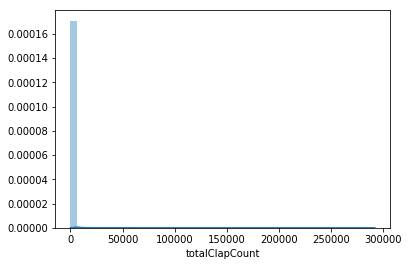

In [0]:
sns.distplot(train_aggregate.totalClapCount)

A cutoff of 20 for the count of publisher appearances to be considered as significant is chosen somewhat arbitrarily. In the space of ~66,000 articles, however, for a publisher to need to only appear 20 times to be considered for conditional expenctancy imputation might be considered liberal.

Regardless, the value for central tendency is taken for all 'low count' publishers to be used in the imputation phase. The target shows a similar distribution amongst this subset.


In [0]:
low = df(train_aggregate['publicationname'].value_counts())
low = list(low[low['publicationname'] <= 20].index)
low_impute = train_aggregate[train_aggregate['publicationname'].isin(low)].totalClapCount.median()
low_impute

16.0

(0, 0.0002)

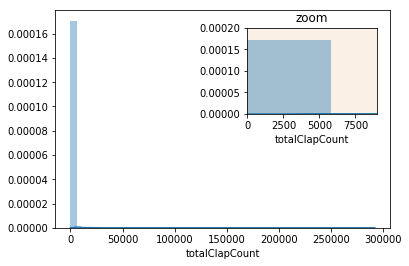

In [0]:
fig, ax = plt.subplots()
sns.distplot(train_aggregate[train_aggregate['publicationname'].isin(low)].totalClapCount)
ax2 = plt.axes([0.57, 0.52, .3, .3], facecolor = 'linen')
sns.distplot(train_aggregate[train_aggregate['publicationname'].isin(low)].totalClapCount, ax = ax2)
ax2.set_title('zoom')
ax2.set_xlim([0, 9000])
ax2.set_ylim([0, .0002])

Finally, grouping by publication name, the following code block assigns the CE values to each row respectively, considering whether or not that row's publisher appears commonly enough. This coding approach, though less, graceful in its appearance, increases greatly the speed at which these values are assigned in the original data frames in comparison to the Pandas .loc method.

In [0]:
publisher_counts = df(train_aggregate['publicationname'].value_counts())
publisher_claps = df(train_aggregate.groupby(['publicationname'])['totalClapCount'].agg('median'))

new_df = publisher_counts.join(publisher_claps, on=publisher_counts.index)
new_df.columns = ['count', 'totalClapCount']
new_df['ce_publisher'] = new_df['totalClapCount']
new_df.loc[new_df['count'] < 20, 'ce_publisher'] = low_impute

x_pub = list(new_df.index)
y_pub = list(new_df.ce_publisher.values)
zip_dict_known_pub = dict(zip(x_pub, y_pub))
zip_dict_unknown_pub = {id: (zip_dict_known_pub[id] if id in zip_dict_known_pub.keys() else low_impute) for id in list(test['publication'].unique())}

train_aggregate['ce_publisher'] = train_aggregate['publicationname'].map(zip_dict_known_pub)
test['ce_publisher'] = test['publication'].map(zip_dict_unknown_pub)

#### Author



In the following blocks, the same process as above is applied.

In [0]:
train_aggregate['author'].value_counts().head(30)

Synced                                377
Yves Mulkers                          279
DEEP AERO DRONES                      278
AI Hawk                               243
Jae Duk Seo                           173
C Gavilanes                           164
TWiML & AI                            136
Michael K. Spencer                    123
Corsair's Publishing                  121
WELTARE Strategies                    115
Vantagepoint ai                       113
Derrick Harris                        112
Jesus Rodriguez                       107
NYU Center for Data Science           105
All Turtles                           103
Peter Marshall                         96
#ODSC - The Data Science Community     92
Daily Wisdom                           90
Sahana Karnam                          88
Neuromation                            80
Leor Grebler, UCIC                     78
Jehoshaphat Abu                        77
Carlos E. Perez                        76
Ilexa Yardley                     

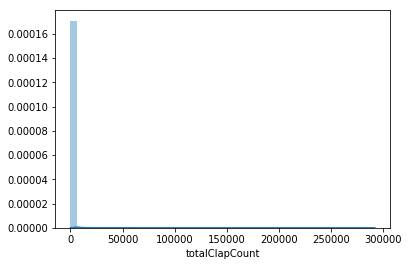

In [0]:
sns.distplot(train_aggregate.totalClapCount)

In [0]:
low = df(train_aggregate['author'].value_counts())
low = list(low[low['author'] <= 20].index)
low_impute = train_aggregate[train_aggregate['author'].isin(low)].totalClapCount.median()
low_impute

6.0

(0, 0.0002)

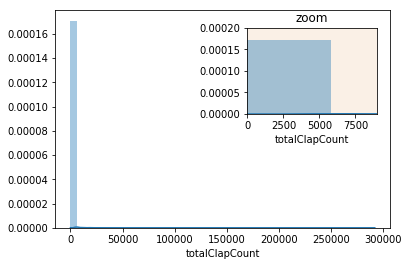

In [0]:
fig, ax = plt.subplots()
sns.distplot(train_aggregate[train_aggregate['author'].isin(low)].totalClapCount)
ax2 = plt.axes([0.57, 0.52, .3, .3], facecolor = 'linen')
sns.distplot(train_aggregate[train_aggregate['author'].isin(low)].totalClapCount, ax = ax2)
ax2.set_title('zoom')
ax2.set_xlim([0, 9000])
ax2.set_ylim([0, .0002])

In [0]:
author_counts = df(train_aggregate['author'].value_counts())
author_claps = df(train_aggregate.groupby(['author'])['totalClapCount'].agg('median'))

new_df = author_counts.join(author_claps, on=author_counts.index)
new_df.columns = ['count', 'totalClapCount']
new_df['ce_author'] = new_df['totalClapCount']
new_df.loc[new_df['count'] < 20, 'ce_author'] = low_impute

x_auth = list(new_df.index)
y_auth = list(new_df.ce_author.values)
zip_dict_known_auth = dict(zip(x_auth, y_auth))
zip_dict_unknown_auth = {id: (zip_dict_known_auth[id] if id in zip_dict_known_auth.keys() else low_impute) for id in list(test['author'].unique())}

train_aggregate['ce_author'] = train_aggregate['author'].map(zip_dict_known_auth)
test['ce_author'] = test['author'].map(zip_dict_unknown_auth)

### Remove Features no Longer Needed

With the CE values for 'publisher' and 'author' calculated, the original features can be safely dropped, as they are now represented numerically for the regressor models below.

In [0]:
train_aggregate = train_aggregate.drop(['author'], axis=1)
train_aggregate = train_aggregate.drop(['publicationname'], axis=1)

In [0]:
test = test.drop(['author'], axis=1)
test = test.drop(['publication'], axis=1)

### Check & Unify Feature Names

In a final cleaning step, feature names are unified and null values are set to 0 or ' ', respectively.

In [0]:
train = train_aggregate
train = train[['title', 'text', 'article_age', 'readingTime', 'responsesCreatedCount', 'ce_publisher', 'ce_author', 'totalClapCount']]
train.rename(columns={
    'title': 'header', 
    'article_age': 'article_age_days', 
    'readingTime': 'read_time', 
    'responsesCreatedCount': 'responses', 
    'totalClapCount': 'claps'
}, inplace=True)

train.dtypes

header               object
text                 object
article_age_days      int64
read_time           float64
responses             int64
ce_publisher        float64
ce_author           float64
claps                 int64
dtype: object

In [0]:
test = test[['header', 'text', 'article_age', 'read_time', 'responses', 'ce_publisher', 'ce_author']]
test.rename(columns={'article_age': 'article_age_days'}, inplace=True)
test.dtypes

header               object
text                 object
article_age_days      int64
read_time           float64
responses             int64
ce_publisher        float64
ce_author           float64
dtype: object

### Final Check for Stray Null Values

In [0]:
train.isnull().sum(axis = 0)

header              0
text                0
article_age_days    0
read_time           0
responses           0
ce_publisher        0
ce_author           0
claps               0
dtype: int64

In [0]:
test.isnull().sum(axis = 0)

header              8
text                0
article_age_days    0
read_time           0
responses           0
ce_publisher        0
ce_author           0
dtype: int64

In [0]:
test['header'] = test['header'].fillna(value='')

<a id='preprocessing'></a>
***
# Text Cleaning & Prep for Embedding

The following cells perform higher-level text pre-processing on the now-clean text from the previous section. This is in preparation for tokenisation and sequencing (via the Keras API), which, in turn, prepares the text as integer-sequenced data for the following neural network models.

### Text Cleaning & Lemmatisation

Below, two functions are defined which carry out the necessary pre-processing steps. A third handles the two operators to reduce operation time (minimise loops needed for functions):

1. further trimming and replacement of in-text content (punctuation removal, white space standardisation, digit removal).
2. lematisation of the text, that is, identifying roots to which original words can be simplified, where appropriate. This differs from stemming in that it reduces words to real-word lemmas or base forms. Stemming, on the other hand, transforms words to sometimes-non-word stems. In practice, both seek to simplify the vocabulary space by which the corpus as a whole is represented. Lemmatisation is preferable here, in part, because the simplified forms remain recognisable. Online blog consensus has these two methods performing similarly, with relatively minor differences in output quality.

#### Operator Functions for Text Cleaning

In [0]:
def cleaner_passover(text):
  """Operator function for initial text cleaning."""
  
  punct_re_string = '|'.join('\\' + char for char in punctuation)
  punct_re_string = r'['+punct_re_string+']'

  text = text.lower()
  text = unidecode.unidecode(text)
  
  text = text.replace('&', ' and ')
  text = text.replace('@', ' at ')
  text = re.sub('[-–—]', '', text)
  text = re.sub(punct_re_string, ' ', text)
  
  text = re.sub(r'\w*\d+\w*', '', text)
  text = re.sub(r'\d', '', text)
  
  text = re.sub('\s\s+' , ' ', text) 
  text = re.sub(r'\w*\d+\w*', '', text)
    
  return text

In [0]:
def lemmatiser_operator(text):
  """Operator function for stemming of text."""
  
  doc = nlp(text)
  text = ' '.join([token.lemma_ for token in doc])
  text = re.sub(r'\-PRON\-', '', text)
  text = re.sub('\s\s+' , ' ', text)
  
  return text

In [0]:
def cleaning_handler(row, df_length):
  """Handler for cleaning functions."""
  
  row['text'] = str(row['text'])
  row['header'] = str(row['header'])
  
  row['text'] = cleaner_passover(row['text'])
  row['text'] = lemmatiser_operator(row['text'])
  
  row['header'] = cleaner_passover(row['header'])
  row['header'] = lemmatiser_operator(row['header'])
  
  print(f'\rcompleted: {row.name} of {df_length}', end='')
  return row

#### Train

In [0]:
df_length = len(train)
train = train.apply(lambda row: cleaning_handler(row, df_length), axis=1)

completed: 64856 of 64857

#### Test

In [0]:
df_length = len(test)
test = test.apply(lambda row: cleaning_handler(row, df_length), axis=1)

completed: 513 of 514

### Define & Remove Stopwords

Removal of 'stopwords' is another critical step to NLP pre-processing. Stopwords in this study are defined customly using the pre-defined spaCy list plus words deemed worthy of removal based on their tf-idf scores in corpus documents.

See below the pre-defined set of stopwords:

In [0]:
stop_words = set([re.sub(r'\W', '', word) for word in nlp.Defaults.stop_words])
pprint(stop_words)

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'd',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give

Now, in order to add to this and custom tailor the stopwords set, the word count and tf-idf values for each individual word are examined using SKLearn's text processing tools. Words with an extremely low tf-idf value or a very high one (and which are visibly most likely to be unhelpful) are added to stopwords set to be removed from documents in the corpus.

Tf-idf scores are chosen over simple word frequency because these scores temper the word's 'count' value (count of occurrences in corpus) by how much meaning it carries in the corpus (in how many unique documents the word appears). For example, by count alone, it appears that the words 'datum' and 'use' should be removed from the corpus. By tf-idf score, however, they appear not nearly so strong as outliers, which suggests they be retained.

This trimming allows for reduction of overall data in the set, which is conducive for faster model training and minimising model complexity. Originally, the cutoff for words to be identified as stopwords is set at tf-idf lower than 8.5 (an estimated parity value for count less than 10 in the corpus). Further trimming turns out to be an improvement in modeling in moving the cutoff to 15. This value corresponds to the summed tf-idf values of all occurrences of a word.

In [0]:
vect_count = CountVectorizer()

word_counts = vect_count.fit_transform(train['text'])
sum_words = word_counts.sum(axis=0)

frequencies = [(word, sum_words[0, idx]) for word, idx in vect_count.vocabulary_.items() if not word in stop_words]
frequencies = sorted(frequencies, key=lambda x: x[1], reverse=True)
print(f'Total words: {len(frequencies)}')

# single_double_words = [word for word, freq in frequencies if freq < 10]
# print(f'Count of words occuring less than 10 times: {len(single_double_words)} \n')

single_double_words = [word for word, freq in frequencies if freq < 20]
print(f'Count of words occuring less than 20 times: {len(single_double_words)} \n')

common_words = frequencies[:20]
for word, frequency in common_words:
    print(word, frequency)

Total words: 275102
Count of words occuring less than 3 times: 245781 

datum 348729
use 302919
ai 186393
model 164025
learn 154262
machine 150407
time 136161
like 130925
work 125284
need 118726
new 114279
human 106781
technology 102200
learning 100437
way 92207
system 90026
good 88605
create 88069
network 87715
people 87231


In [0]:
vect_tf_idf = TfidfVectorizer()

td_idf_scores = vect_tf_idf.fit_transform(train['text'])
sum_words = td_idf_scores.sum(axis=0)

scores = [(word, sum_words[0, idx]) for word, idx in vect_tf_idf.vocabulary_.items() if not word in stop_words]
scores = sorted(scores, key=lambda x: x[1], reverse=True)
print(f'Total words: {len(scores)}')

# low_count_words = [word for word, score in scores if score < 8.5]
# print(f'Count of words scoring less than 8.5: {len(low_count_words)} \n')

low_count_words = [word for word, score in scores if score < 15]
print(f'Count of words scoring less than 15: {len(low_count_words)} \n')

common_words = scores[:20]
for word, score in common_words:
    print(word, score)

Total words: 275102
Count of words scoring less than 15: 269916 

datum 2678.1209512841424
ai 2077.9240771897057
use 1882.4590451530596
model 1462.4121512712418
machine 1456.829987938186
learn 1349.2377822360345
human 1163.8750794446064
technology 1127.022463284017
learning 1070.5602866715665
intelligence 1031.8649935249703
time 1018.693905269032
work 1010.365451887266
like 1000.7157700073776
new 971.5533689148978
business 948.5974916330052
customer 945.708762448197
need 945.0473459561978
company 938.8083142007061
network 938.339094054791
image 911.9812603325247


In [0]:
single_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
combined_custom_stopwords = set(single_double_words + low_count_words + single_letters)
stop_words.update(combined_custom_stopwords)
print(f'Count stop words: {len(stop_words)}')

Count stop words: 270248


Here, stop words are removed, checking every word in the corpus against the chopping-block list.

In [0]:
for col in ['header', 'text']:
    train[col] = train[col].apply(lambda text: ' '.join(word for word in str(text).split() if word not in stop_words))
    test[col] = test[col].apply(lambda text: ' '.join(word for word in str(text).split() if word not in stop_words))

<a id='keras'></a>
***

## Keras Tokenising & Sequencing

Keras offers a tokenising and sequencing API for representing text data as numeric values. Under the hood, the tokeniser does some similar pre-processing like that done above; however, it is expected that most has already been taken care of. It then gives every word a unique integer identifier, which is then used by the sequencer, which turns an article into a list of its words' integer representations.

Originally, from the first pass of the stopword trimming, the word space is 7450, give or take. After more aggressive trimming, the final value stands at 5180 words in the minimised corpus. With 'header' and 'text' columns now represented as lists of integers, they are nearly ready to be fed to the Keras embedding layers, where all of the magic happens.

Keras tokenisation, sequencing, and embedding is the chosen method for this problem as it is generally understood to be the most precise approach to training word embeddings. When training an embedding layer in a NN, the embeddings are optimised specifically to the target feature and loss function. In this way, it is assumed that Keras embeddings are more suitable than unsupervised embedding algorithms like word2vec or fasttext. These embeddings still derive contenctual features from text but are not able to do so in the context of the target and are not directly trainable.

In [0]:
# tokenizer = text.Tokenizer(num_words=7450, oov_token='new')
tokenizer = text.Tokenizer(num_words=5180, oov_token='new')

In [0]:
tokenizer.fit_on_texts(train['text'].astype(str))
train_sequences_text = tokenizer.texts_to_sequences(train['text'].astype(str))
test_sequences_text = tokenizer.texts_to_sequences(test['text'].astype(str))

In [0]:
tokenizer.fit_on_texts(train['header'].astype(str))
train_sequences_header = tokenizer.texts_to_sequences(train['header'].astype(str))
test_sequences_header = tokenizer.texts_to_sequences(test['header'].astype(str))

In [0]:
train['text'] = train_sequences_text
train['header'] = train_sequences_header

test['text'] = test_sequences_text
test['header'] = test_sequences_header

### Identify Suitable Window Width for Vector Input Length

Before the sequences can be used as input for a standardised model, they must also be prepared as standardised input. This means unifying the length of the 'header' and 'text' features at some central value.

Looking at density estimates of the distributions of article / header lengths (in words), an appropriate standard length can be defined. In the following cells, these distributions are plotted and window widths defined.

In [0]:
train['review_length_text'] = train['text'].apply(lambda text: len(str(text).split()))
train['review_length_header'] = train['header'].apply(lambda text: len(str(text).split()))

#### Text

In [0]:
print(f'max review length: {train.review_length_text.max()}')
print(f'min review length: {train.review_length_text.min()}')
print(f'average review length: {train.review_length_text.mean()}')
print(f'median review length: {median(train.review_length_text)}')

max review length: 9954
min review length: 1
average review length: 399.88419137487085
average review length: 317


(0, 0.0022)

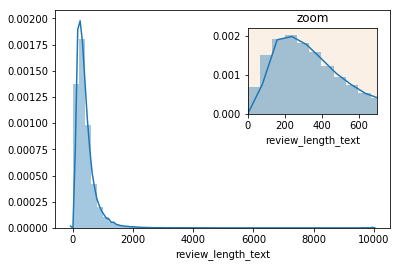

In [0]:
fig, ax = plt.subplots()
sns.distplot(train['review_length_text'])
ax2 = plt.axes([0.57, 0.52, .3, .3], facecolor = 'linen')
sns.distplot(train['review_length_text'], ax = ax2, bins=150)
ax2.set_title('zoom')
ax2.set_xlim([0, 700])
ax2.set_ylim([0, .0022])

Again, with the skewed distribution, median appears to be a more sensible central tendency measure to use, though the values are much closer here than in the conditional expectation calculations.

In [0]:
window_text = 325

#### Header

In [0]:
print(f'max review length: {train.review_length_header.max()}')
print(f'min review length: {train.review_length_header.min()}')
print(f'average review length: {train.review_length_header.mean()}')
print(f'median review length: {median(train.review_length_header)}')

max review length: 49
min review length: 1
average review length: 4.34454260912469
average review length: 4


(0, 0.5)

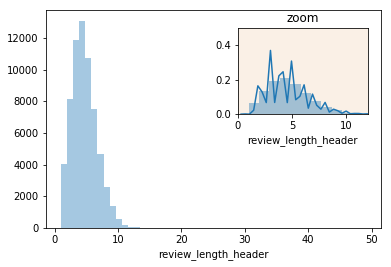

In [0]:
fig, ax = plt.subplots()
sns.distplot(train['review_length_header'], kde=False)
ax2 = plt.axes([0.57, 0.52, .3, .3], facecolor = 'linen')
sns.distplot(train['review_length_header'], ax = ax2, bins=50)
ax2.set_title('zoom')
ax2.set_xlim([0, 12])
ax2.set_ylim([0, .5])

The same logic applies here. The value 5 is chosen, as the additional space is deemed not to be harmful.

In [0]:
window_header = 5

<a id='modeling'></a>
***
# Modeling

This notebook shows that the recurrent neural network works as an effective tool for processing unstructured text data and regressing it to a target variable. It additionally showcases the advantages of the Keras functional API and the value of employing text alongside tabular data in an RNN model.

The structure of a given neural network can vary greatly in terms of its component layers and hyperparameters that dictate the manner in which, and how fast the network learns. This makes it difficult, without experience and expertise, to know exactly how to structure a network. This is also variable depending on the nature of the data at hand. For this reason, the best approach is to apply a hyperparameter tuning tool, in order to 'canvas' a space of possible network architectures (also educated guesses).

In the following experiments, such a tool is set up and run part-way; however, due to server time limitations with Google Colab, the grid search, estimated to take 26 hours or so, is not able to be completed. The first of the prospective 15 models trained produce good (low) loss values. None, however, beat the non-Hyperas edition of the complete network. This will be discussed in more detail in the closing thoughts.

As benchmarking for judging network efficacy, simple neural networks and non-net machine learning algorithms are employed. This is to provide a baseline against which the final RNNs can be compared in order to build context into the experiment.

## Load & Prep of Test / Train Data

### Define Data Read & Prep Functions

The following functions perform the read-in and final pre-processing (sequence padding) of the data before partitioning it into test-train splits and returning it for use. These functions are required for the Hyperas hyperparameter-tuning model architecture explained later on.

In [0]:
def data():
  """Data providing function for networks."""
    
  os.chdir('/gdrive/My Drive/colab_notebooks/final_assignment/data/interim_data')
    
  with open('interim_train_02.pickle', 'rb') as handle:
    train = pickle.load(handle)
    
  X = train[[col for col in train.columns if not col == 'claps']]
  y = train['claps'].values
  y = np.reshape(y, (-1,1))
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
    
  # Format train data slices.
    
  X_train_text = X_train['text']
  X_train_header = X_train['header']
  X_train_data = X_train[[col for col in X_train.columns if col not in ['header', 'text', 'review_length_text', 'review_length_header']]]

  X_train_text = pad_sequences(X_train_text, maxlen=325, padding='post')
  X_train_header = pad_sequences(X_train_header, maxlen=5, padding='post')

  # Format test data slices.
    
  X_test_text = X_test['text']
  X_test_header = X_test['header']
  X_test_data = X_test[[col for col in X_test.columns if col not in ['header', 'text', 'review_length_text', 'review_length_header']]]

  X_test_text = pad_sequences(X_test_text, maxlen=325, padding='post')
  X_test_header = pad_sequences(X_test_header, maxlen=5, padding='post')

  return X_train_text, X_train_header, X_train_data, y_train, X_test_text, X_test_header, X_test_data, y_test

In [0]:
def test():
  """Data providing function for test data."""
    
  os.chdir('/gdrive/My Drive/colab_notebooks/final_assignment/data/interim_data')
  
  with open('interim_test_02.pickle', 'rb') as handle:
    test = pickle.load(handle)
  
  os.chdir('/gdrive/My Drive/colab_notebooks/final_assignment/data/')
           
  test_original = pd.read_csv('test.csv')
  test_index = test_original['index']
    
  test_text = test['text']
  test_header = test['header']
  test_data = test[[col for col in test.columns if col not in ['header', 'text']]]

  test_text = pad_sequences(test_text, maxlen=325, padding='post')
  test_header = pad_sequences(test_header, maxlen=5, padding='post')
 
  return test_text, test_header, test_data, test_original

### Prepare Train Data (run 'data()' function)

In [0]:
X_train_text, X_train_header, X_train_data, y_train, X_test_text, X_test_header, X_test_data, y_test = data()

### Prepare Test Data (run 'test()' function)

In [0]:
test_text, test_header, test_data, test_original = test()

<a id='benchmarks'></a>
***
## Non-NN Models

Given only the numeric data points, Random Forest and XGBoost regressors both fail to produce impressive results with the training set. With the constructed and cleaned features from previous sections available to the models, both models overfit fairly heavily here.

The mean squared error scores of 5429300.19 (RF) & 5792100.29 (XGB) contrast quite clearly to the MSE value of 3164531.70 for the winning neural network, providing a good foundation for confirmation that the text processing capabilities of the networks provide significant value.

In [0]:
y_test_tabular = y_test.ravel()
y_train_tabular = y_train.ravel()

### Random Forest

In [12]:
rfc = RandomForestRegressor(n_estimators=250)
rfc.fit(X_train_data, y_train_tabular)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
rfc_preds = rfc.predict(X_test_data)
rfc_preds_train = rfc.predict(X_train_data)

In [14]:
print(mean_squared_error(y_test_tabular, rfc_preds))
print(mean_squared_error(y_train_tabular, rfc_preds_train))

5429300.191732826
98629.78105060039


In [42]:
df(rfc.feature_importances_, index=X_test_data.columns, columns=['Importance'])

,Importance
article_age_days,0.112026
read_time,0.143188
responses,0.651453
ce_publisher,0.075864
ce_author,0.017469


### XGBoost

In [39]:
xgb = xgboost.XGBRegressor(n_estimators=250, n_jobs=2)
xgb.fit(X_train_data, y_train_tabular)

[10:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
xgb_preds = xgb.predict(X_test_data)
xgb_preds_train = xgb.predict(X_train_data)

In [41]:
print(mean_squared_error(y_test, xgb_preds))
print(mean_squared_error(y_train, xgb_preds_train))

5792100.299312368
185315.7458854961


In [26]:
df(xgb.feature_importances_, index=X_test_data.columns, columns=['Importance'])

,Importance
article_age_days,0.093054
read_time,0.165773
responses,0.487977
ce_publisher,0.188132
ce_author,0.065064


<a id='nns'></a>
***
## Neural Networks

All neural networks are constructed as GRU RNNs using the Keras functional API. This, in comparison to the sequential API, allows for easy input of data which will follow different pipelines within the network. The GRU network is quite similar to the LSTM, though has a quicker training time in general. Outputs can are expected to be comparable. For this reason, the GRU is chosen as the recurrent unit of choice.

The implementation of the GAP (Global Average Pooling) layer after each recurrent node is both necessary and beneficial to the functioning of the network, transforming the matrix output of the GRU sequences into a vector which can be fed to the next layer, be it another GRU or the concatenation layer.

The NN section is split into three subsections:
  - Test Multi-Layer Efficacy (looking at the benefits of deep RNNs for this data)
  - Hyperas hyperparameter tuning
  - Final submission and highest-scoring network

### Test Multi-Layer Efficacy

The following networks serve to test the efficacy of adding multiple recurrent layers (i.e. making a deep RNN). Given only 10 epochs each, the results aren't overwhelmingly conclusive. They do, however, indicate which configuration is preferable. Using only the text body data for these networks, there is a clear increase in loss reduction from 1 layer to 2 layers. It seems, within the scope of these 10-epoch tests, that a third recurrent network does not increase loss reduction and, in fact, appears to harm it.

Perhaps, with more training, the 3-layer network could prove to be more effective, but with the added processing time of another recurrent layer, the 2-layer architecture appears to be perfectly valid and is what is used in all networks sporting a more complex architecture.

#### 1-Layer Model

In [0]:
def build_GRU_Keras_1():
  """Constructor for GRU network to test 2-layer depth."""
  
  input_layer_text = Input(shape=(325, ))
  
  # Text Data
  embedded_text = Embedding(output_dim=524, input_dim=5180, input_length=325, trainable=True)(input_layer_text)
  rn_1_text = GRU(346, return_sequences=True)(embedded_text)
  rn_1_text = Dropout(0.2)(rn_1_text)
  text_pooled = GlobalAveragePooling1D()(rn_1_text)
  
  output_layer = Dense(1, activation='relu')(text_pooled)
  
  model = Model(inputs=[input_layer_text], outputs = output_layer)
  model.compile(loss = 'mean_squared_error',
                optimizer = RMSprop(clipvalue=1, clipnorm=1),
                metrics=['mse'])
  
  print(model.summary())
  return model

In [0]:
model_GRU_Keras = build_GRU_Keras_1()
model_GRU_Keras.fit([X_train_text], y_train, 
                    epochs=10, verbose=1, batch_size=700,
                    validation_data=([X_test_text], y_test))

model_GRU_Keras.save('keras_gru_1_layer.h5')

W0811 13:10:28.015902 140128443385728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 13:10:28.073991 140128443385728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 13:10:28.084988 140128443385728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 13:10:28.505311 140128443385728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 13:10:28.517847 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 325)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 325, 524)          2714320   
_________________________________________________________________
gru_1 (GRU)                  (None, 325, 346)          904098    
_________________________________________________________________
dropout_1 (Dropout)          (None, 325, 346)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 346)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 347       
Total params: 3,618,765
Trainable params: 3,618,765
Non-trainable params: 0
_________________________________________________________________


W0811 13:10:29.485064 140128443385728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0811 13:10:30.041892 140128443385728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 45399 samples, validate on 19458 samples
Epoch 1/10
45399/45399 [==============================] - 138s 3ms/step - loss: 1484677.0662 - mean_squared_error: 1484677.0662 - val_loss: 8805897.6520 - val_mean_squared_error: 8805897.6520
Epoch 2/10
45399/45399 [==============================] - 129s 3ms/step - loss: 1478736.9323 - mean_squared_error: 1478736.9323 - val_loss: 8800847.5695 - val_mean_squared_error: 8800847.5695
Epoch 3/10
45399/45399 [==============================] - 129s 3ms/step - loss: 1474628.6128 - mean_squared_error: 1474628.6128 - val_loss: 8802064.2049 - val_mean_squared_error: 8802064.2049
Epoch 4/10
45399/45399 [==============================] - 129s 3ms/step - loss: 1471407.8367 - mean_squared_error: 1471407.8367 - val_loss: 8801845.9965 - val_mean_squared_error: 8801845.9965
Epoch 5/10
45399/45399 [==============================] - 129s 3ms/step - loss: 1470080.3269 - mean_squared_error: 1470080.3269 - val_loss: 8804578.6643 - val_mean_squared_error: 880

#### 2-Layer Model

In [0]:
def build_GRU_Keras_2():
  """Constructor for GRU network to test 2-layer depth."""
  
  input_layer_text = Input(shape=(325, ))
  
  # Text Data
  embedded_text = Embedding(output_dim=524, input_dim=5180, input_length=325, trainable=True)(input_layer_text)
  rn_1_text = GRU(346, return_sequences=True)(embedded_text)
  rn_1_text = Dropout(0.2)(rn_1_text)
  
  rn_2_text = GRU(268, return_sequences=True)(rn_1_text)
  rn_2_text = Dropout(0.1)(rn_2_text)
  text_pooled = GlobalAveragePooling1D()(rn_2_text)
  
  output_layer = Dense(1, activation='relu')(text_pooled)
  
  model = Model(inputs=[input_layer_text], outputs = output_layer)
  model.compile(loss = 'mean_squared_error',
                optimizer = RMSprop(clipvalue=1, clipnorm=1),
                metrics=['mse'])
  
  print(model.summary())
  return model

In [0]:
model_GRU_Keras = build_GRU_Keras_2()
model_GRU_Keras.fit([X_train_text], y_train, 
                    epochs=10, verbose=1, batch_size=700,
                    validation_data=([X_test_text], y_test),
                    callbacks = callbacks)

model_GRU_Keras.save('keras_gru_2_layer.h5')

W0811 02:24:32.786487 139758185002880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 02:24:32.832372 139758185002880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 02:24:32.841977 139758185002880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 02:24:33.266034 139758185002880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 02:24:33.280019 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 325)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 325, 524)          2714320   
_________________________________________________________________
gru_1 (GRU)                  (None, 325, 346)          904098    
_________________________________________________________________
dropout_1 (Dropout)          (None, 325, 346)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 325, 268)          494460    
_________________________________________________________________
dropout_2 (Dropout)          (None, 325, 268)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 268)               0         
__________

W0811 02:24:34.666847 139758185002880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0811 02:24:35.885587 139758185002880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 45399 samples, validate on 19458 samples
Epoch 1/10
45399/45399 [==============================] - 225s 5ms/step - loss: 1485863.6214 - mean_squared_error: 1485863.6214 - val_loss: 8808528.7862 - val_mean_squared_error: 8808528.7862
Epoch 2/10
45399/45399 [==============================] - 216s 5ms/step - loss: 1481139.3681 - mean_squared_error: 1481139.3681 - val_loss: 8803751.1832 - val_mean_squared_error: 8803751.1832
Epoch 3/10
45399/45399 [==============================] - 215s 5ms/step - loss: 1477555.8376 - mean_squared_error: 1477555.8376 - val_loss: 8801017.4034 - val_mean_squared_error: 8801017.4034
Epoch 4/10
45399/45399 [==============================] - 215s 5ms/step - loss: 1474387.0604 - mean_squared_error: 1474387.0604 - val_loss: 8799107.0881 - val_mean_squared_error: 8799107.0881
Epoch 5/10
45399/45399 [==============================] - 215s 5ms/step - loss: 1472305.9659 - mean_squared_error: 1472305.9659 - val_loss: 8798998.7588 - val_mean_squared_error: 879

#### 3-Layer Model

In [0]:
def build_GRU_Keras_3():
  """Constructor for GRU network to test 3-layer depth."""

  input_layer_text = Input(shape=(325, ))

  # Text Data
  embedded_text = Embedding(output_dim=524, input_dim=5180, input_length=325, trainable=True)(input_layer_text)
  rn_1_text = GRU(346, return_sequences=True)(embedded_text)
  rn_1_text = Dropout(0.2)(rn_1_text)

  rn_2_text = GRU(268, return_sequences=True)(rn_1_text)
  rn_2_text = Dropout(0.2)(rn_2_text)

  rn_3_text = GRU(184, return_sequences=True)(rn_2_text)
  rn_3_text = Dropout(0.1)(rn_3_text)
  text_pooled = GlobalAveragePooling1D()(rn_3_text)

  output_layer = Dense(1, activation='relu')(text_pooled)
  
  model = Model(inputs=[input_layer_text], outputs = output_layer)
  model.compile(loss = 'mean_squared_error',
                optimizer = RMSprop(clipvalue=1, clipnorm=1),
                metrics=['mse'])

  print(model.summary())
  return model

In [0]:
model_GRU_Keras = build_GRU_Keras_3()
model_GRU_Keras.fit([X_train_text], y_train, 
                    epochs=10, verbose=1, batch_size=700,
                    validation_data=([X_test_text], y_test),
                    callbacks = callbacks)

model_GRU_Keras.save('keras_gru_3_layer.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 325)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 325, 524)          2714320   
_________________________________________________________________
gru_3 (GRU)                  (None, 325, 346)          904098    
_________________________________________________________________
dropout_3 (Dropout)          (None, 325, 346)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 325, 268)          494460    
_________________________________________________________________
dropout_4 (Dropout)          (None, 325, 268)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 325, 184)          250056    
__________

### Hyperas Hyperparameter Tuning

Hyperparameter tuning is a key step in any machine learning model training exercise. Often the 'correct' cocktail of hyperparameters is not obvious at first, foremost because it often depends on the nature of the particular data at hand, which will always require a somewhat bespoke approach. In the case of neural networks, this issue increases many fold as the network architecture increases in complexity. Each layer includes a set of hyperparameters, and a complex network can have a number of unique layer configurations. 

Enter: Hyperas. Hyperas functions similar to scikit-learn's Random CV grid search technique, taking a space of predefined values for different network hyperparameters (output dimensions, epochs, etc.) and testing different permutations amongst them. This creates a model space where the engine then chooses the model with the greatest accuracy (lowest loss value).

In the following code block, a model similar to the winning model is prepared with the Hyperas 'choice' syntax, indicating where values for layers or other hyperparameters are variable. Unfortunately, models of this size take 2-4 hours each to train. At an attempted 15 permutations, this is 24+ hours of training. A bot that clicks the screen every 30 seconds was created to attempt to keep the Google Colab server instance active while the Hyperas process runs; however, this turns out not to keep the session active. After 3 or 4 models, the server times out and the tuning run is not complete.

Initial trainings from this method seem promising, and, with faster / more devoted computing power, Hyperas would be expected to produce a very highly-scoring model. For this project, however the idea is ultimately scrapped, as the first-attempted model architecture and fourth hyperparameter constellation prove to produce a very satisfactory result. The code is nonetheless documented below:

In [0]:
def build_GRU_Keras_Master():
  """Constructor for GRU network to be used with Keras embeddings."""
  
  input_layer_text = Input(shape=(325, ))
  input_layer_header = Input(shape=(5, ))
  input_layer_data = Input(shape=(5, ))
  
  output_dimension = {{choice([128, 256, 512])}}
  gru_large = {{choice([250, 350, 450])}}
  gru_medium = {{choice([120, 150, 180])}}
  gru_small = {{choice([64, 84])}}
  
  # Text Data
  embedded_text = Embedding(output_dim=output_dimension, input_dim=5180, input_length=325, trainable=True)(input_layer_text)
  rn_1_text = GRU(gru_large, return_sequences=True)(embedded_text)
  rn_1_text = Dropout(0.2)(rn_1_text)
  
  rn_2_text = GRU(gru_medium, return_sequences=True)(rn_1_text)
  pool_in = Dropout({{uniform(0, .5)}})(rn_2_text)
  
  if {{choice(['two', 'three'])}} == 'three':
        pool_in = GRU(gru_small, return_sequences=True)(pool_in)
        pool_in = Dropout({{uniform(0, 1)}})(pool_in)
  
  text_pooled = GlobalAveragePooling1D()(pool_in)
  
  # Header Data
  embedded_header = Embedding(output_dim=output_dimension, input_dim=5180, input_length=5, trainable=True)(input_layer_header)
  rn_1_header = GRU(gru_medium, return_sequences=True)(embedded_header)
  rn_1_header = Dropout({{uniform(0, .5)}})(rn_1_header)
  header_pooled = GlobalAveragePooling1D()(rn_1_header)
  
  # Numeric Data
  dense_data = Dense({{choice([64, 128])}}, activation='relu')(input_layer_data)
  dense_data = Dense({{choice([64, 128])}}, activation='relu')(input_layer_data)
  
  # Concatenate & Out
  concatenated = concatenate([text_pooled, header_pooled, dense_data])
  output_layer = Dense(1, activation='relu')(concatenated)
  
  model_GRU_Keras = Model(inputs=[input_layer_text, input_layer_header, input_layer_data], outputs = output_layer)
  model_GRU_Keras.compile(loss = 'mean_squared_error',
                          optimizer = RMSprop(clipvalue=1, clipnorm=1),
                          metrics=['mse'])
  
  os.chdir('/gdrive/My Drive/colab_notebooks/final_assignment/data/model_checkpoints')
  callbacks = [ModelCheckpoint(filepath='KERAS_GRU_Master_{epoch:02d}-{val_loss:.2f}.hdf5'), 
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                             min_delta=1e-4, restore_best_weights=True)]
  
  result = model_GRU_Keras.fit([X_train_text, X_train_header, X_train_data], y_train, 
                               epochs=60, verbose=1, batch_size={{choice([256, 564, 724])}},
                               validation_data=([X_test_text, X_test_header, X_test_data], y_test),
                               callbacks = callbacks)
  
  validation_loss = np.amin(model_GRU_Keras.history.history['val_loss']) 
  print('Lowest validation loss of epoch:', validation_loss)
  return {'loss': validation_loss, 'status': STATUS_OK, 'model': model_GRU_Keras}


In [0]:
os.chdir('/gdrive/My Drive/colab_notebooks/final_assignment')
best_run, best_model = optim.minimize(model=build_GRU_Keras_Master, 
                                      data=data,
                                      algo=tpe.suggest, 
                                      max_evals=15, 
                                      trials=Trials(),
                                      notebook_name='medium_net')

print("Best performing model w/ chosen hyper-parameters:")
best_model.save('keras_gru_winner.h5')
pprint(best_run)

In [0]:
model_GRU_Keras = load_model('keras_gru_winner.h5')
predictions = model_GRU_Keras.predict([test_text, test_header, test_data], verbose=1)

In [0]:
predictions_clean = [np.array([0]) if prediction < 0 else prediction for prediction in predictions]
test_ids = test_original.index

predictions_out = df(predictions_clean, index=test_ids, columns=['Claps'])
predictions_out['index'] = predictions_out.index
predictions_out = predictions_out[['index', 'Claps']]

predictions_out.to_csv('../predictions/prediction_gru_master.csv', index=False)

### Winning Model & Final Submission

The model below is that which produces the final and 'winning' score in the Kaggle competition public leaderboard. This network takes three inputs:
  - Body text of article
  - Header text of article
  - Tabular (numeric) data
  
The benefit of the functional Keras API is that it provides a simple interface by which to input multiple data sources into a single network. Inputs to specific layers are also defined, allowing substructures within the net through which different data sources are fed through individual pipelines. These layers are arbitrarily ordered from top to bottom in the code, as they are ultimately being concatenated at the end – whichever substructures finish first are still left waiting for the others before completing a sequence.

Once all pipelines within the network have been completed, the outputs are concatenated and then fed to a 1-node dense layer for regression. ReLU is chosen as the activation function as it sets all negative outputs to 0 (there can be no negative claps). Positive outputs remain unchanged.

At 60 epochs and a relatively small batch size, the model is given ample time and diversity of samples to produce a predictor that is, ideally, not overfitting too much. Using Keras' callback parameter, training is stopped after the 5th consecutive epoch with no improvement in test validation loss. In the case that this occurs, the epoch with the best loss optimisation is restored and output as the 'winning' model.


**Note: the output for this model below is not the version which produced the highest scoring kaggle model... but the original output print was accidentally deleted. What is shown below is the same network architecture but a different run.

In [0]:
def build_GRU_Keras_04():
  """Constructor for GRU network to be used with Keras embeddings."""
  
  input_layer_text = Input(shape=(325, ))
  input_layer_header = Input(shape=(5, ))
  input_layer_data = Input(shape=(5, ))
  
  # Text Data
  embedded_text = Embedding(output_dim=128, input_dim=5180, input_length=325, trainable=True)(input_layer_text)
  rn_1_text = GRU(450, return_sequences=True)(embedded_text)
  rn_1_text = Dropout(0.2)(rn_1_text)
  
  rn_2_text = GRU(225, return_sequences=True)(rn_1_text)
  pool_in = Dropout(0.1)(rn_2_text)
  text_pooled = GlobalAveragePooling1D()(pool_in)
  
  # Header Data
  embedded_header = Embedding(output_dim=50, input_dim=5180, input_length=5, trainable=True)(input_layer_header)
  rn_1_header = GRU(128, return_sequences=True)(embedded_header)
  rn_1_header = Dropout(0.2)(rn_1_header)
  header_pooled = GlobalAveragePooling1D()(rn_1_header)
  
  # Numeric Data
  dense_data = Dense(128, activation='relu')(input_layer_data)
  
  # Concatenate & Out
  concatenated = concatenate([text_pooled, header_pooled, dense_data])
  output_layer = Dense(1, activation='relu')(concatenated)
  
  model = Model(inputs=[input_layer_text, input_layer_header, input_layer_data], outputs = output_layer)
  model.compile(loss = 'mean_squared_error', optimizer = RMSprop(clipvalue=1, clipnorm=1), metrics=['mse'])
  
  print(model.summary())
  return model

In [29]:
os.chdir('/gdrive/My Drive/colab_notebooks/final_assignment/data/model_checkpoints')
callbacks = [ModelCheckpoint(filepath='KERAS_GRU_04_{epoch:02d}-{val_loss:.2f}.hdf5'), 
             EarlyStopping(monitor='val_loss', patience=5, verbose=1,
             min_delta=1e-4, restore_best_weights=True)]

model_GRU_Keras = build_GRU_Keras_04()
model_GRU_Keras.fit([X_train_text, X_train_header, X_train_data], y_train, 
                    epochs=60, verbose=1, batch_size=256,
                    validation_data=([X_test_text, X_test_header, X_test_data], y_test),
                    callbacks = callbacks)

model_GRU_Keras.save('keras_gru_04.h5')    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 325)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 325, 128)     663040      input_4[0][0]                    
__________________________________________________________________________________________________
gru_4 (GRU)                     (None, 325, 450)     781650      embedding_3[0][0]                
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
dropout_4 

In [26]:
predictions = model_GRU_Keras.predict([test_text, test_header, test_data], verbose=1)

514/514 [==============================] - 7s 14ms/step


In [0]:
predictions_clean = [np.array([0]) if prediction < 0 else prediction for prediction in predictions]
test_ids = test_original['index']

predictions_out = df(predictions_clean, index=test_ids, columns=['Claps'])
predictions_out['index'] = predictions_out.index
predictions_out = predictions_out[['index', 'Claps']]

predictions_out.to_csv('/gdrive/My Drive/colab_notebooks/final_assignment/data/predictions/prediction_fourth_gru.csv', index=False)

<a id='conclusions'></a>
***
# Conclusions

### Summary

In this experiment, GRUs of various builds are employed, using simple networks and tabular-data-oriented machine learning models (RF & XGBoost) as benchmarks for measuring the performance delta when employing final, more comprehensive neural net models. Ultimately, the deep RNN architecture in the final subsection of the modeling section produces the best-performing model in terms of mean-squared error loss. Drawing from basic testing of RNN optimal depth, the count of RNN layers in the final model is set to two (though in the Hyperas canvas, there is still and option for a third). It could also be possible that added depth for the tabular data layer(s) could produce further-improved results. Regardless of these maybes, however, the model in its current form does perform to satisfaction.


A large component of the successful training of the end-use model is the extensive data cleaning and preparation for the final neural networks. This is considered to be the strong point of this notebook and a pivotal lever upon which greater test results are achieved. The relative messiness / disunity of the test and train sets (though likely existing, in this case, on purpose for the sake of challenge) highlights the importance of consistency in data collection, especially in the case of data scraping, where the raw data format is often rife errors in consistency.

### Prior Knowledge

Expertise and know-how for this task were derived from the completion of mini challenge 2, in which a text classification problem required the prediction of star reviews fro e-commerce products. This differs from the current challenge, in which the nature of prediction is regression, rather than classification. This doesn't change the pre-processing steps; however, it does modify somewhat the modeling approach. Also a departure from MC2, the embeddings in this experiment are carried out by way of Keras' embedding layer. This is a theoretical improvement over the unsupervised word2vec and fasttext embeddings used in past pre-processing pipelines, as explained previously. A good foundation in Python programming and data manipulation also make the modification / cleaning of original data much more efficient, painless, and effective... even fun at times!

### Final Notes

A working implementation of the Hyperas hyperparameter tuning suite is be the obvious next step for this project. In general, running complex neural network architectures using large data sets is more tenable with access to great processing power and managed resources (i.e. cloud computing solutions). Additionally, some value selections in both pre-processing and modeling were made as educated guesses. Further development of background and theoretical knowledge on the cutting edge of neural network practitionership / engineering would also bring a welcome degree of added assuredness to designing similar models in the future.

***

A link to the Google Drive directory with (nearly) all supporting documents is here:

https://drive.google.com/drive/folders/14sv8S8_zbn-k4793_PrV8xFofDskv-aE?usp=sharing